##Problem Statement

Clicks is a stock photography company and is an online source of images available for people and companies to download. Photographers from all over the world upload food-related images to the stock photography agency every day. Since the volume of the images that get uploaded daily will be high, it will be difficult for anyone to label the images manually.

Clicks have decided to use only three categories of food (Bread, Soup, and Vegetables-Fruits) for now, you as a data scientist at Clicks, need to build a classification model using a dataset consisting of images that would help to label the images into different categories.

##Importing the Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
import os
import cv2

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import losses
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import LabelBinarizer

import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Unzip the images from the data file.
!unzip /content/Food_Data.zip

##Reading the Data

In [14]:
def create_data_set(data_set, DATADIR, CATEGORIES, IMG_SIZE):
  for category in CATEGORIES:
    #Take the path of the dataset and add the category name to the end of it.
    path = os.path.join(DATADIR,category)
    class_num = category
    #Iterate over the images
    for img in os.listdir(path):
      #read the image in
      img_array = cv2.imread(os.path.join(path,img))
      #resize the image
      new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
      #add it to the output dataset.
      data_set.append([new_array, class_num])
  return data_set

In [15]:
#These are the categories of food in this dataset.
CATEGORIES =  [ "Bread", "Soup", "Vegetable-Fruit"]

IMG_SIZE = 150 # the image size to resize all the images too.

In [16]:
#File path to the training data.
DATADIR = '/content/Food_Data/Training'

#Empty list to return the results of the function.
training_data_set_list = []

#Create the training_data set.
training_data_set = create_data_set(training_data_set_list, DATADIR, CATEGORIES, IMG_SIZE)

In [17]:
#File path to the testing data.
DATADIR = '/content/Food_Data/Testing'

#Empty list to return the results of the function.
testing_data_set_list = []

#Create the tresting_data set.
testing_data_set = create_data_set(testing_data_set_list, DATADIR, CATEGORIES, IMG_SIZE)

#Visualization of the data sets

In [83]:
# Creating 3 lists to store the image names for each category by reading them from their directories.
# Loop over the path of each image from each classification directory.
bread_imgs = [fn for fn in os.listdir(f'{DATADIR}/{CATEGORIES[0]}') ]
soup_imgs = [fn for fn in os.listdir(f'{DATADIR}/{CATEGORIES[1]}')]
veg_fruit_imgs = [fn for fn in os.listdir(f'{DATADIR}/{CATEGORIES[2]}') ]

# Ranodmly selecting 3 images from each category
select_bread = np.random.choice(bread_imgs, 3, replace = False)
select_soup = np.random.choice(soup_imgs, 3, replace = False)
select_veg_fruit = np.random.choice(veg_fruit_imgs, 3, replace = False)

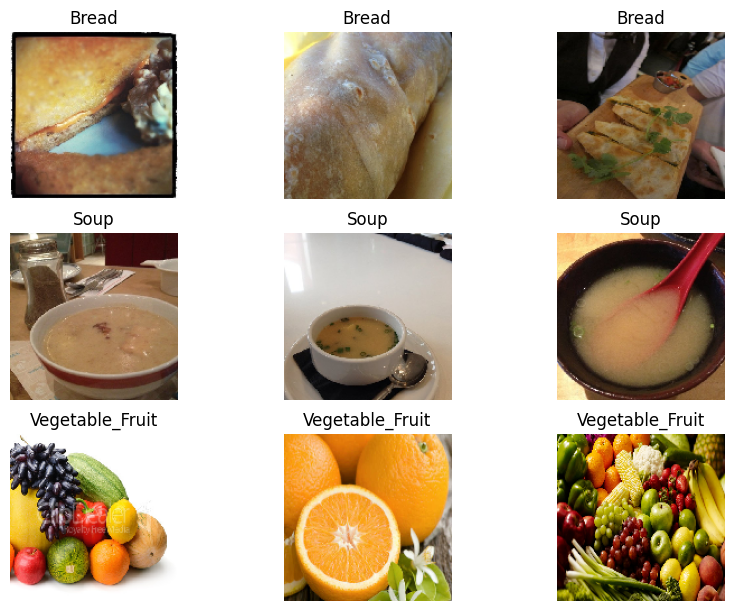

In [84]:
# plotting 4 x 3 image matrix
fig = plt.figure(figsize = (10,10))

# Plotting three images from each of the four categories by looping through their path
for i in range(9):
    #If statements are in intervals of 3 to produce 3 random images from each class
    if i < 3:
        fp = f'{DATADIR}/{CATEGORIES[0]}/{select_bread[i]}'
        label = 'Bread'
    if i>=3 and i<6:
        fp = f'{DATADIR}/{CATEGORIES[1]}/{select_soup[i-3]}'
        label = 'Soup'
    if i>=6 and i<9:
        fp = f'{DATADIR}/{CATEGORIES[2]}/{select_veg_fruit[i-6]}'
        label = 'Vegetable_Fruit'
    ax = fig.add_subplot(4, 3, i+1)

    # Plotting each image using load_img function
    fn = image.load_img(fp, target_size = (150,150))
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')
plt.show()

#Data Preprocessing

In [18]:
#Create the x and y training sets
X_train = []
y_train = []

np.random.shuffle(training_data_set)
for features, label in training_data_set:
  X_train.append(features)
  y_train.append(label)

In [19]:
#Create the x and y testing sets
X_test = []
y_test = []

np.random.shuffle(training_data_set)
for features, label in training_data_set:
  X_test.append(features)
  y_test.append(label)

In [20]:
# Converting the list into DataFrame
y_train = pd.DataFrame(y_train, columns=["Label"],dtype=object)
y_test = pd.DataFrame(y_test, columns=["Label"],dtype=object)

## Class Balance Check

In [21]:
count = y_train.Label.value_counts()
print(count)
print("*"*10)
percent = y_train.Label.value_counts(normalize=True)
print(percent)

Label
Soup               1500
Bread               994
Vegetable-Fruit     709
Name: count, dtype: int64
**********
Label
Soup               0.468311
Bread              0.310334
Vegetable-Fruit    0.221355
Name: proportion, dtype: float64


These classes are some what imblanced. There is more than twice as many images of Soup than Vegetable-Fruit.

#Building the Model

##Data Preprocessing

In [22]:
#Convert the feature vectors into numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)

In [23]:
X_train.shape

(3203, 150, 150, 3)

###Normalization

In [24]:
#Divide all the pixels in the images to put them on a scale of 0-1.
X_train_norm = X_train.astype('float32')/255.0
X_test_norm = X_test.astype('float32')/255.0

###One-Hot Encoding

In [25]:
#Encoding the target variable will transform each instance into an array that is one-hot encoded.
lb = LabelBinarizer()

y_train_enc = lb.fit_transform(y_train)

y_test_enc = lb.transform(y_test)

##Model 1

In [99]:
backend.clear_session()

np.random.seed(32)
random.seed(32)
tf.random.set_seed(32)

In [120]:
model_1 = Sequential()

#First convolution layer
#Keeping padding the same so the output will be the same size as the input.
model_1.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(150, 150, 3)))

#Adding a maxpooling layer to reduce the size of the first conv layer.
model_1.add(MaxPooling2D((2, 2), padding = 'same'))

#Additional conv and pooling layers
model_1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_1.add(MaxPooling2D((2, 2), padding = 'same'))
model_1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model_1.add(MaxPooling2D((2, 2), padding = 'same'))

#Flatten the output of the pooling layer to prepare for the fully connected layer.
model_1.add(Flatten())

#Fully connected layers
model_1.add(Dense(128, activation='relu'))
model_1.add(Dense(64, activation='relu'))
model_1.add(Dense(32, activation='relu'))

#Output layer
model_1.add(Dense(3, activation='softmax'))


In [121]:
#Optimizers
opt = SGD(learning_rate=0.01, momentum=0.9)

In [122]:
model_1.compile(
    optimizer = opt,
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

In [123]:
model_1.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)                   │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 75, 75, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 38, 38, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 38, 38, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 19, 19, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 11552)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │       1,478,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,518,723 (5.79 MB)

 Trainable params: 1,518,723 (5.79 MB)

 Non-trainable params: 0 (0.00 B)

In [124]:
#Early stopping will stop the model learning if the val_loss doesn't improve after 5 iterations.
ear_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
history_1 = model_1.fit(
    X_train_norm,
    y_train_enc,
    epochs = 30,
    batch_size = 32,
    validation_split = 0.1,
    callbacks = [ear_stop]
)

Epoch 1/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.4552 - loss: 1.0700 - val_accuracy: 0.4798 - val_loss: 1.0444
Epoch 2/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.4598 - loss: 1.0630 - val_accuracy: 0.4922 - val_loss: 1.0505
Epoch 3/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.4737 - loss: 1.0214 - val_accuracy: 0.5607 - val_loss: 0.9198
Epoch 4/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.5822 - loss: 0.8551 - val_accuracy: 0.5763 - val_loss: 0.8780
Epoch 5/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.6022 - loss: 0.8117 - val_accuracy: 0.5732 - val_loss: 0.8146
Epoch 6/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.6208 - loss: 0.7521 - val_accuracy: 0.6168 - val_loss: 0.7406
Epoch 7/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.6569 - loss: 0.6863 - val_accuracy: 0.6137 - val_loss: 0.7852
Epoch 8/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.6754 - loss: 0.6560 - val_accuracy: 0.6355 - v

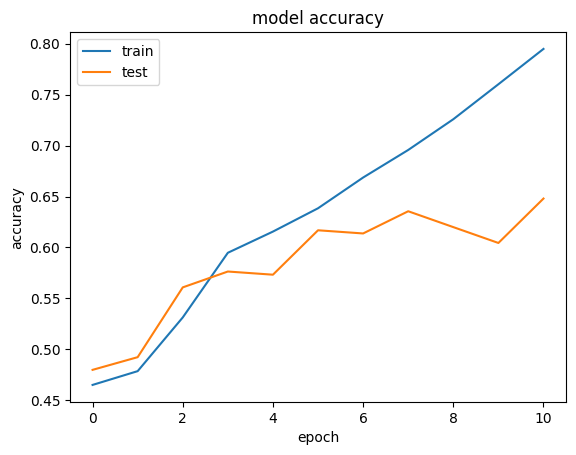

In [125]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

From the above graph, it appear the model is overfitting.

In [126]:
model_1.evaluate(X_test_norm, y_test_enc, verbose=2)

101/101 - 42s - 420ms/step - accuracy: 0.7290 - loss: 0.8148


[0.8148295879364014, 0.7290040850639343]

The test accuracy shown above is about 73%.

In [127]:
y_pred = model_1.predict(X_test_norm)

101/101 ━━━━━━━━━━━━━━━━━━━━ 41s 407ms/step


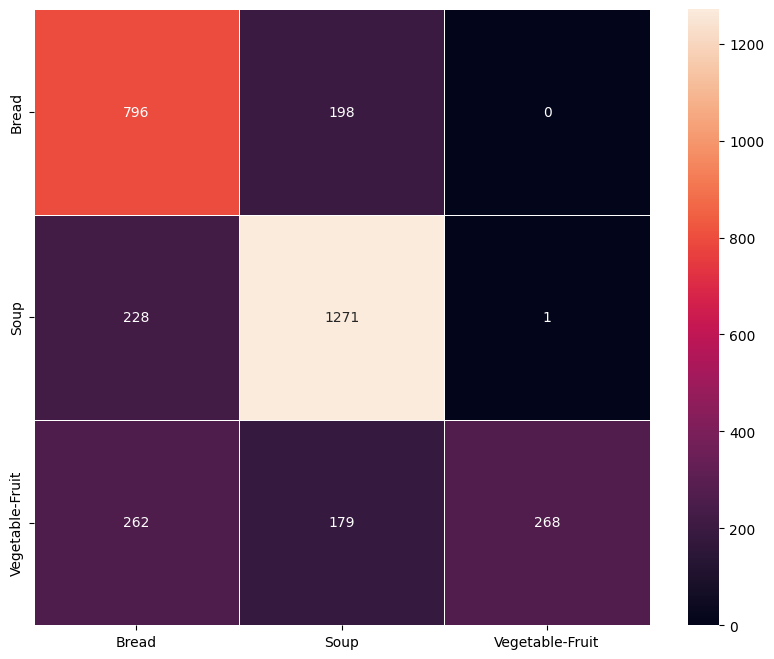

In [131]:
#Get the max value over each category to get the class for the prediction and the actual.
y_pred_arg = np.argmax(y_pred, axis=1)
y_test_arg = np.argmax(y_test_enc, axis=1)

#Plot the confusion matrix
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred_arg)
fig , ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt='d',
    square=True,
    ax=ax,
    xticklabels = CATEGORIES,
    yticklabels = CATEGORIES
)
plt.show()

There appear to be a fair bit of class confusion shown in the confusion matrix above. Despite the moderate accuracy of the model it does mislabel the images 27% of the time

##Model 2

In [164]:
backend.clear_session()

np.random.seed(32)
random.seed(32)
tf.random.set_seed(32)

In [165]:
model_2 = Sequential()

#First convolution layer
#Keeping padding the same so the output will be the same size as the input.
model_2.add(Conv2D(64, (5,5), activation='relu', padding='same', input_shape=(150, 150, 3)))

#Adding a maxpooling layer to reduce the size of the first conv layer.
model_2.add(MaxPooling2D((2, 2), padding = 'same'))

#Additional conv and pooling layers
model_2.add(Conv2D(128, (5, 5), activation='relu', padding="same"))
model_2.add(MaxPooling2D((2, 2), padding = 'same'))
model_2.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model_2.add(MaxPooling2D((2, 2), padding = 'same'))
#Adding a dropout layer.
model_2.add(Dropout(0.2))

#Flatten the output of the pooling layer to prepare for the fully connected layer.
model_2.add(Flatten())

#Fully connected layers
model_2.add(Dense(128, activation='relu'))
#Adding a dropout layer.
model_2.add(Dropout(0.2))
model_2.add(Dense(64, activation='relu'))
model_2.add(Dropout(0.2))
model_2.add(Dense(32, activation='relu'))

#Output layer
model_2.add(Dense(3, activation='softmax'))

In [166]:
model_2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 64)        │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 38, 38, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 38, 38, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 19, 19, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 19, 19, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 23104)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,957,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,251,459 (12.40 MB)

 Trainable params: 3,251,459 (12.40 MB)

 Non-trainable params: 0 (0.00 B)

In [167]:
#Optimizers
opt = SGD(learning_rate=0.01, momentum=0.9)

In [168]:
model_2.compile(
    optimizer = opt,
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

In [169]:
ear_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
history_2 = model_2.fit(
    X_train_norm,
    y_train_enc,
    epochs = 30,
    batch_size = 64,
    validation_split = 0.1,
    callbacks = [ear_stop]
)

Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 0.4494 - loss: 1.0714 - val_accuracy: 0.4361 - val_loss: 1.0634
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.4701 - loss: 1.0444 - val_accuracy: 0.4361 - val_loss: 1.0472
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.4762 - loss: 0.9905 - val_accuracy: 0.5140 - val_loss: 0.9753
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.5306 - loss: 0.9176 - val_accuracy: 0.4361 - val_loss: 1.0619
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.4679 - loss: 1.0177 - val_accuracy: 0.4361 - val_loss: 1.0722
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.4765 - loss: 0.9793 - val_accuracy: 0.5452 - val_loss: 1.0063
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.5930 - loss: 0.7967 - val_accuracy: 0.5234 - val_loss: 1.0036
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.5946 - loss: 0.8059 - val_accuracy: 0.6075 -

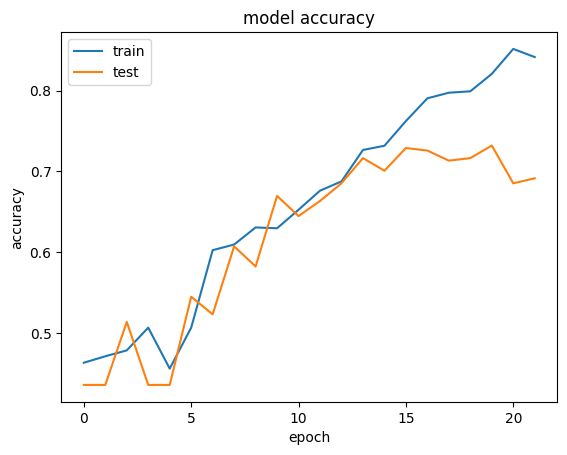

In [170]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [171]:
model_2.evaluate(X_test_norm, y_test_enc, verbose=2)

101/101 - 2s - 21ms/step - accuracy: 0.8692 - loss: 0.3642


[0.36417651176452637, 0.8691851496696472]

In [172]:
y_pred = model_2.predict(X_test_norm)

101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


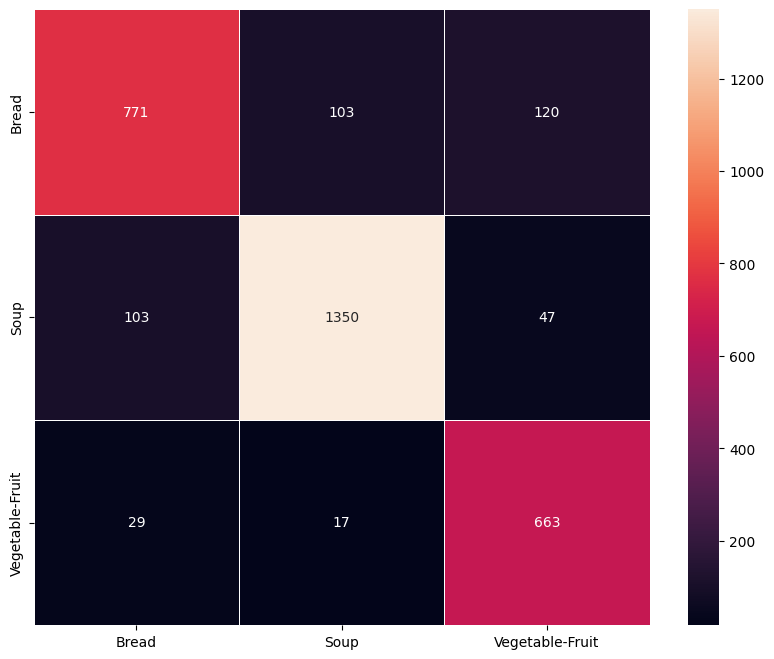

In [173]:
#Get the max value over each category to get the class for the prediction and the actual.
y_pred_arg = np.argmax(y_pred, axis=1)
y_test_arg = np.argmax(y_test_enc, axis=1)

#Plot the confusion matrix
confusion_matrix = tf.math.confusion_matrix(y_test_arg, y_pred_arg)
fig , ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt='d',
    square=True,
    ax=ax,
    xticklabels = CATEGORIES,
    yticklabels = CATEGORIES
)
plt.show()

In [1]:
!jupyter nbconvert --to html /content/FoodimageClassification.ipynb

[NbConvertApp] Converting notebook /content/FoodimageClassification.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 5 image(s).
[NbConvertApp] Writing 1392056 bytes to /content/FoodimageClassification.html
